In [1]:
import numpy as np
from imports import *

Tomo = Tomography()

In [2]:
#Specify the shape of the images, the number of images in the sequence and load the image sequence using the gen_seq_function
nx= 64

ny = nx
shape = (nx,ny)
size = nx*ny
t_end = 2

v_max = 1
v_min = 1
padding = 2
data = gen_im_seq(shape,t_end,v_max=v_max,v_min=v_min, padding =padding)
u_traj = data.u_traj
u_inv_traj = data.u_inv_traj
v_primes=data.v_primes
vs=data.vs

# A list of the locations of all pixels
R = np.array(list(np.ndindex(*shape)))
# u_traj = [u*10 for u in u_traj]

plt.set_cmap('inferno')

u_traj_ = np.load('mnist_test_seq.npy')[:,0,:,:][0:t_end]#*10
u_traj = [vec(u) for u in u_traj_]
u_inv_traj=u_traj[::-1]

v_max = 3


<Figure size 640x480 with 0 Axes>

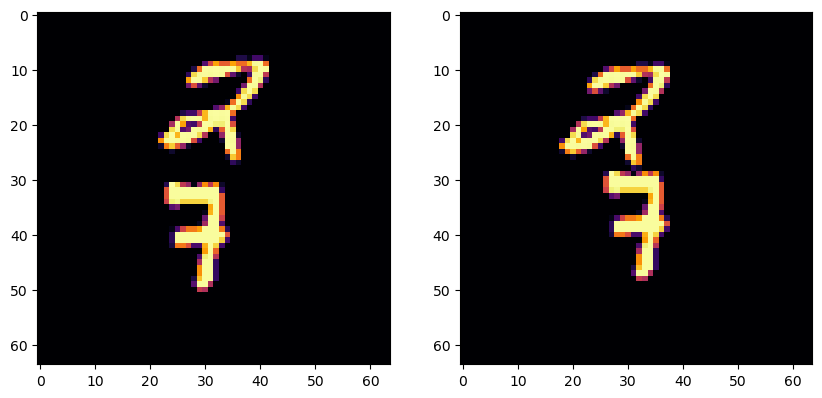

In [3]:
fig,ax=plt.subplots(1,t_end,figsize=(10,5))
for i in range(0,t_end):
    ax[i].imshow(u_traj[i].reshape(shape))

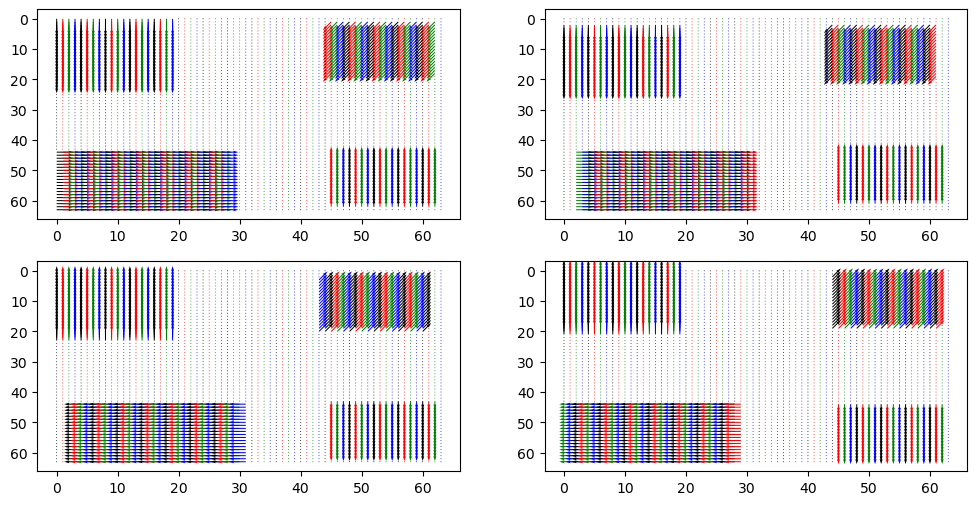

In [4]:
data_inv = [v_primes[i].reshape((nx**2,2)) for i in range(t_end-1)]
data_ =  [vs[i].reshape((nx**2,2)) for i in range(t_end-1)]

origin = [np.array(R)[:,1], np.array(R)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), 
# color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(6*(t_end-1),3*(t_end-1)))
if (t_end <=2):
    ax = ax.reshape((-1,1))
for i in range(len(data_)):
    ax[0,i].quiver(*origin, data_[i][:, 1], -data_[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()
    ax[1,i].quiver(*origin, data_inv[i][:, 1], -data_inv[i][:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[1,i].invert_yaxis()


In [17]:
#Generate the sinogram and the operator
views = 11
noise_level = 1e-2
x_traj = u_traj


X_true, A_bar,data_vec_bar,data_vec_true_bar,b_shape,L_bar, I_bar,deltas = gen_joint_tomo_op_and_data(x_traj, t_end, nx,ny, views,
                                                                           noise_level, case='a')
b_size = b_shape[0]*b_shape[1]
delta = np.mean(deltas) #la.norm(data_vec_true_bar-data_vec_bar)
print(delta)


378.44160156250007


Text(0.5, 0.98, 'Noisy sinograms of the images in the sequence')

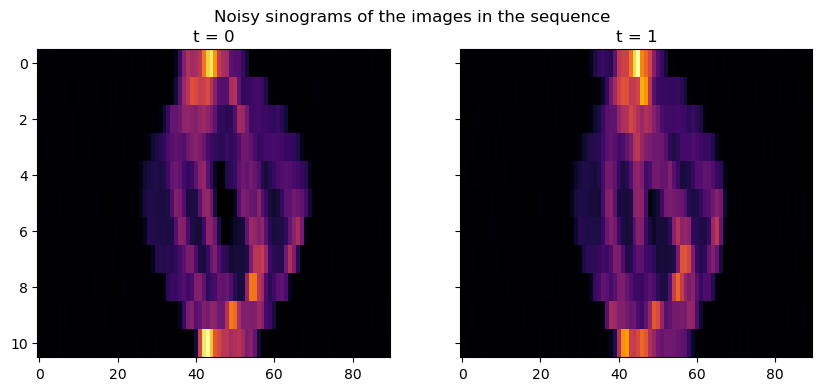

In [14]:
fig,ax=plt.subplots(1,t_end, sharey=True, figsize=(10,4))
data_vec_bar_list_c = [data_vec_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
data_vec_true_bar_list_c = [data_vec_true_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
for i in range(0,t_end):
    ax[i].imshow(data_vec_bar_list_c[i].reshape(b_shape),aspect='auto')
    ax[i].set_title(f't = {i}')
fig.suptitle('Noisy sinograms of the images in the sequence')

In [4]:

def MMGKS_dyn_joint_(A, b, L_,I, t_end,shape,pnorm=2, qnorm=1, rnorm= 1, projection_dim=3, n_iter=5, n_iter_b=60,
regparam='gcv', vs_true = None, v_primes_true = None, v_max = None, x_true=None, min_l = 0,max_l=1,opt='nonscaled', non_neg= True, pnorm_opt=1,qnorm_opt = 1, proj_dim_opt = 1, interval=1,**kwargs):
    def M_mat(u,v):
        R = np.array(list(np.ndindex(*u.shape)))
        nx = u.shape[0]
        ny = u.shape[1]
        new_ind = (v.reshape(nx*ny,2)+R).astype(int)
        new_ind[new_ind>nx-1] = nx-1
        new_ind[new_ind<0] = 0
        v_prime=np.zeros((nx,ny,2))
        v_prime[new_ind[:,0],new_ind[:,1]] = -v.reshape(nx*ny,2)
        inds = [ind[0]*nx+ind[1] for ind in new_ind]
        rows = [i for i in range(len(inds))]
        cols = [inds[i] for i in range(len(inds))]
        data = [1 for i in range(len(inds))]
        M_ = scipy.sparse.coo_matrix((data, (rows,cols)),shape = (nx*ny,nx*ny))
        M_ = M_.tocsr()
        return M_,v_prime
    nx = shape[0];ny = shape[1]

    dp_stop = kwargs['dp_stop'] if ('dp_stop' in kwargs) else False
    epsilon = kwargs['epsilon'] if ('epsilon' in kwargs) else 0.1
    scale = kwargs['scale'] if ('scale' in kwargs) else 2
    reduction = kwargs['reduction'] if ('reduction' in kwargs) else False
    (U, B, V) = golub_kahan_2(A, b, projection_dim, dp_stop, **kwargs)
    
    x_history = []
    lambda_history = []
    alpha_history = []
    residual_history = []
    e = 1
    x = A.T @ b # initialize x for reweighting

    for ii in tqdm(range(n_iter), desc='running MMGKS...'):
        # compute reweighting for p-norm approximation
        v = A @ x - b
        x_ = x.reshape((-1,))

        len_=nx*ny
        x_traj = [x[len_*i:len_*(i+1)] for i in range(t_end)]
        if ((ii%interval == 0)):
            if vs_true is not None: 
                v_ests = vs_true 
            else: 
                _,v_ests,_ = solve_opt_flow(x_traj,shape=shape,t_end=t_end,v_trues=None,v_max=v_max,n_iter=n_iter_b,reduction = reduction, 
                                            scale = scale,pnorm=pnorm_opt,qnorm=qnorm_opt,proj_dim=proj_dim_opt) #solve_opt_flow(x_traj,shape,t_end)
                v_ests = np.rint(np.array(v_ests))

            Ms = []
            v_primes_=[]
            for t in range (t_end-1): 
                M_v_prime =   M_mat(im_func(x_[(t_end - t -1)*(x_.shape[0]//t_end):(t_end - t)*(x_.shape[0]//t_end)],shape), v_ests[::-1][t].reshape((nx,ny,2)))
                Ms.append(M_v_prime[0])
                v_primes_.append(M_v_prime[1])
            Ms.reverse()

            x_traj = [x[len_*i:len_*(i+1)] for i in range(t_end)]

            if v_primes_true is not None: 
                v_inv_ests = v_primes_true
            else: 
                v_inv_ests = v_primes_ #solve_opt_flow_b(x_inv_traj,shape,t_end,None,v_max,n_iter_b) #solve_opt_flow(x_inv_traj,shape,t_end)
                v_inv_ests = np.rint(np.array(v_inv_ests))

            M_primes = [x_[0:1*(x_.shape[0]//t_end)]]
            M_primes = []
            for t in range (t_end-1):   
                M_primes.append(M_mat(im_func(x_[t*(x_.shape[0]//t_end):(t+1)*(x_.shape[0]//t_end)],shape), v_inv_ests[::-1][t].reshape((nx,ny,2)))[0])

            I1 = scipy.sparse.identity(nx*ny)

            M_top = [scipy.sparse.hstack(i*[scipy.sparse.csr_matrix((nx*ny,nx*ny))] + [I1, -Ms[i]] + (len(Ms)-i-1)*[scipy.sparse.csr_matrix((nx*ny,nx*ny))]) for i in range(len(Ms))]
            M_bottom = [scipy.sparse.hstack(i*[scipy.sparse.csr_matrix((nx*ny,nx*ny))] + [-M_primes[i],I1] + (len(M_primes)-i-1)*[scipy.sparse.csr_matrix((nx*ny,nx*ny))]) for i in range(len(M_primes))]

            M = scipy.sparse.vstack((*M_top,*M_bottom))
            M = scipy.sparse.csr_matrix(M)

        #L = scipy.sparse.vstack((L_,M))

        AV = A@V
        LV_ = L_@V
        MV = M@V

        v = A @ x - b
        u = L_@x
        z= M@x
        
        
        wf = ((v**2 + epsilon**2)**(pnorm/2 - 1))
        AA = AV*(wf**(1/2))
        (Q_A, R_A) = la.qr(AA, mode='economic')
        
        wm = ((z**2 + epsilon**2)**(rnorm/2 - 1))
        MM = MV * wm
        
        
        wr = smoothed_holder_weights(u, epsilon=epsilon, p=qnorm).reshape((-1,1))
        LL_ = LV_ * wr
        
        LL = np.concatenate((LL_,MM))
        (Q_L, R_L) = la.qr(LL, mode='economic') 

            
        if regparam == 'dp':
            lambdah = discrepancy_principle(Q_A, R_A, R_L, wf *b, **kwargs)
            w2 = lambdah
            f_max = 1
            g_max = 1
            y,_,_,_ = np.linalg.lstsq(np.concatenate((R_A, np.sqrt(lambdah) * R_L)), np.concatenate((Q_A.T@ b, np.zeros((R_L.shape[0],1)))),rcond=None)
        elif regparam == 'gcv':
            lambdah = generalized_crossvalidation_2(Q_A, R_A, R_L, wf *b, **kwargs)
            w2 = lambdah
            f_max = 1
            g_max = 1
            y,_,_,_ = np.linalg.lstsq(np.concatenate((R_A, np.sqrt(lambdah) * R_L)), np.concatenate((Q_A.T@ b, np.zeros((R_L.shape[0],1)))),rcond=None)
        elif regparam == 'new': 
                
            x2 = np.linalg.lstsq(np.concatenate(((1-min_l)*R_A, (min_l)* R_L)), 
                            np.concatenate(((1-min_l)*Q_A.T@ b, np.zeros((R_L.shape[0],1)))),rcond=None) [0]

            x1 = np.linalg.lstsq(np.concatenate(((min_l)*R_A, (1-min_l)* R_L)), 
                            np.concatenate(((min_l)*Q_A.T@ b, np.zeros((R_L.shape[0],1)))),rcond=None) [0]


            f_max = la.norm(AA@x1-b)**2
            g_max = la.norm(LL@x2)**2

            AA = AA/np.sqrt(f_max)
            LL = LL/np.sqrt(g_max)
            b_=b/np.sqrt(f_max)

            (Q_A, R_A) = la.qr(AA, mode='economic') 
            (Q_L, R_L) = la.qr(LL, mode='economic')
            
            lambdah = gg(AA,Q_A,R_A,b_,LL,Q_L,R_L,np.zeros((LL.shape[0],1)))
            w1 = 1
            w2 = lambdah**2
            y,_,_,_ = np.linalg.lstsq(np.concatenate((w1*R_A, (lambdah) * R_L)), 
                        np.concatenate((w1*Q_A.T@ b_, (lambdah) *np.zeros((R_L.shape[0],1)))),rcond=None)
        else:
            lambdah = regparam
        lambda_history.append(lambdah)


        x = V @ y
        
        if (non_neg):
            x[x<0] = 0
        x_history.append(x)
        if ii >= R_L.shape[0]:
            break

        ra = wf * (AV @ y - b)/f_max
        ra = A.T @ ra
        rb = wr * (LV_ @ y)/g_max
        rb = L_.T @ rb
        rc = wm * (MV @ y)/g_max
        rc = M.T @ rc

        w1 = 1

        r = w1**2* ra + w2 * (rb + rc)
        r = r - V @ (V.T @ r)
        r = r - V @ (V.T @ r)

        vn = r / np.linalg.norm(r)
        V = np.column_stack((V, vn))
        Avn = A @ vn
        AV = np.column_stack((AV, Avn))

        Lvn = L_*vn
        LV = np.column_stack((LV_, Lvn))
        Mvn = M*vn
        MV = np.column_stack((MV, Mvn))
        residual_history.append(la.norm(r))

    if x_true is not None:
        x_true_norm = la.norm(x_true)
        rre_history = [la.norm(x - x_true)/x_true_norm for x in x_history]
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history,'regParam2_history': alpha_history, 'relError': rre_history, 'Residual': residual_history, 'its': ii,'Ms':Ms}
    else:
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history, 'Residual': residual_history, 'its': ii}
    
    return (x, info, v_ests, v_inv_ests)


In [20]:
#Number of iterations for the optical flow solution


n_iter = 300
n_iter_b = 20
proj_dim = 2
vs_true = None# vs 
v_primes_true= None#v_primes 
reduction = True
scale = 2
epsilon=1e-1
non_neg = True
# v_max = 4


# MMGKS

from imports import *
from trips.solvers.MMGKS import *
# (X_mmgks_, info_mmgks_) = MMGKS(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
#                         n_iter =n_iter, regparam = 'gcv', x_true = X_true.reshape((-1,1)), epsilon=epsilon,delta=delta)
# error_mmgks_ = info_mmgks_['relError'][-1]
# X_mmgks_list_ = [X_mmgks_[size*i:size*(i+1)] for i in range(t_end)]
# print(error_mmgks_)


# (X_mmgks_2, info_mmgks_2) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
#                         n_iter =n_iter, regparam = 'gcv', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
# error_mmgks_2 = info_mmgks_2['relError'][-1]
# X_mmgks_list_2 = [X_mmgks_2[size*i:size*(i+1)] for i in range(t_end)]
# print(error_mmgks_2)
##MMGKS

(X_mmgks, info_mmgks) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,delta=delta,non_neg=non_neg)
error_mmgks = info_mmgks['relError'][-1]

X_mmgks[X_mmgks<0]=0
X_mmgks_list = [X_mmgks[size*i:size*(i+1)] for i in range(t_end)]

print('MMGKS Solution relative error:', error_mmgks)


## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=1, qnorm_opt=1,non_neg=non_neg,interval=50)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...:   0%|          | 0/300 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 300/300 [38:39<00:00,  7.73s/it]   


MMGKS Solution relative error: 0.12941664203980915


running MMGKS...: 100%|██████████| 300/300 [03:58<00:00,  1.26it/s]

Dynamic MMGKS Solution relative error: 0.15823914599205696


In [22]:
(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=2, qnorm_opt=2,non_neg=non_neg,interval=50)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)

running MMGKS...: 100%|██████████| 300/300 [04:30<00:00,  1.11it/s]

Dynamic MMGKS Solution relative error: 0.1579894229225457


In [23]:
(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=1, qnorm_opt=1,non_neg=non_neg)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)

running MMGKS...: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]

Dynamic MMGKS Solution relative error: 0.44865800130173755


In [16]:
from trips.solvers.MMGKS import *
L = gen_spacetime_derivative_operator(nx, ny, t_end)

# Use GKS to compute an approximate solution
(X_TV_iso, info_TV_iso) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
                                regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, isoTV = 'isoTV', prob_dims = (nx,ny, t_end),delta=delta)
error_TV_iso = info_TV_iso['relError'][-1]
X_TV_iso[X_TV_iso<0]=0
X_TV_iso_list = [X_TV_iso[size*i:size*(i+1)] for i in range(t_end)]
print('TV iso Solution relative error:', error_TV_iso)

running MMGKS...: 100%|██████████| 100/100 [00:13<00:00,  7.61it/s]

TV iso Solution relative error: 0.5079803752323304


In [13]:
error_mmgks_dyn = info_mmgks_dyn['relError']
error_mmgks = info_mmgks['relError']
error_TV_iso = info_TV_iso['relError']

plt.plot(error_mmgks,label='MMGKS')
plt.plot(error_mmgks_dyn,label='Dynamic MMGKS')
# plt.plot(error_TV_iso,label='ISO TV')
plt.legend()
plt.xlabel('Iteration') 
plt.grid('minor')
plt.ylabel('Relative error')
plt.title('Relative errors',va='bottom');

NameError: name 'info_TV_iso' is not defined

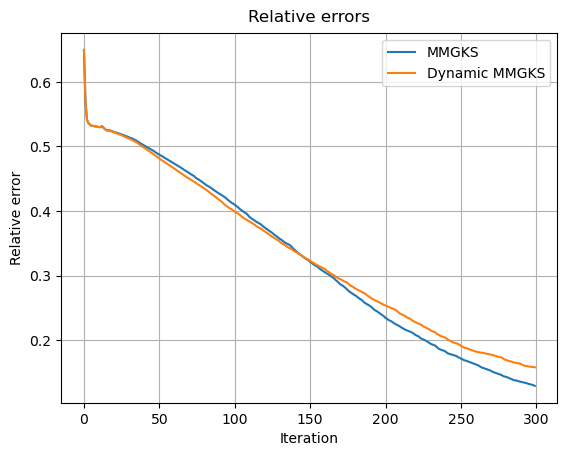

In [21]:
error_mmgks_dyn = info_mmgks_dyn['relError']
error_mmgks = info_mmgks['relError']
# error_TV_iso = info_TV_iso['relError']

plt.plot(error_mmgks,label='MMGKS')
plt.plot(error_mmgks_dyn,label='Dynamic MMGKS')
# plt.plot(error_TV_iso,label='ISO TV')
plt.legend()
plt.xlabel('Iteration') 
plt.grid('minor')
plt.ylabel('Relative error')
plt.title('Relative errors',va='bottom');

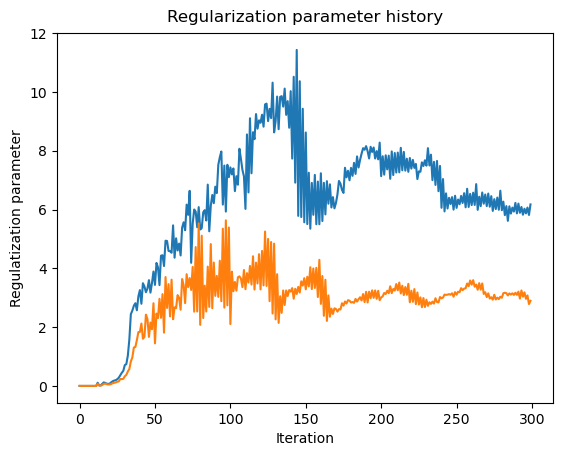

In [23]:
reg_param_mmgks = info_mmgks['regParam_history']
reg_param_mmgks_dyn = info_mmgks_dyn['regParam_history']

plt.plot(reg_param_mmgks)
plt.plot(reg_param_mmgks_dyn)
plt.xlabel('Iteration') 
plt.ylabel('Regulatization parameter')
plt.title('Regularization parameter history',va='bottom');

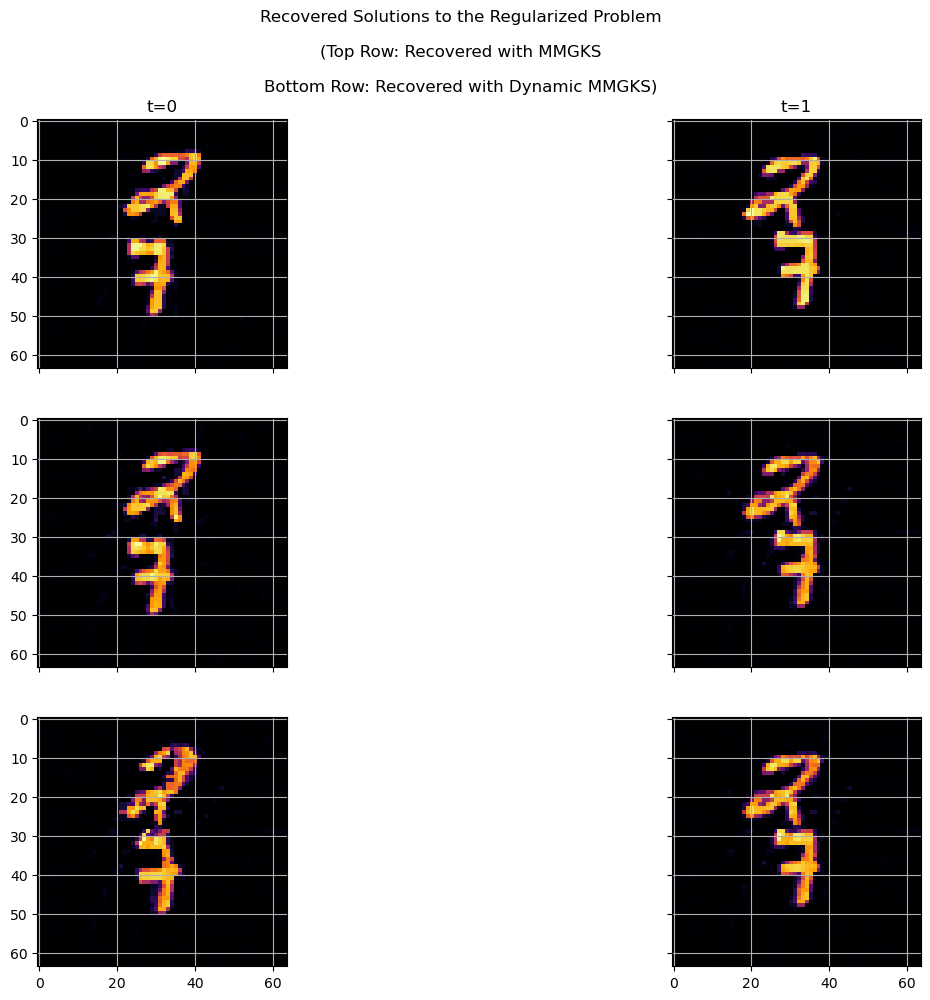

In [24]:
fig,ax=plt.subplots(3,t_end,figsize=(15,11),sharex=True, sharey=True)
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[2,i].imshow(rec_list[::-1][i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    ax[2,i].grid('minor')
plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

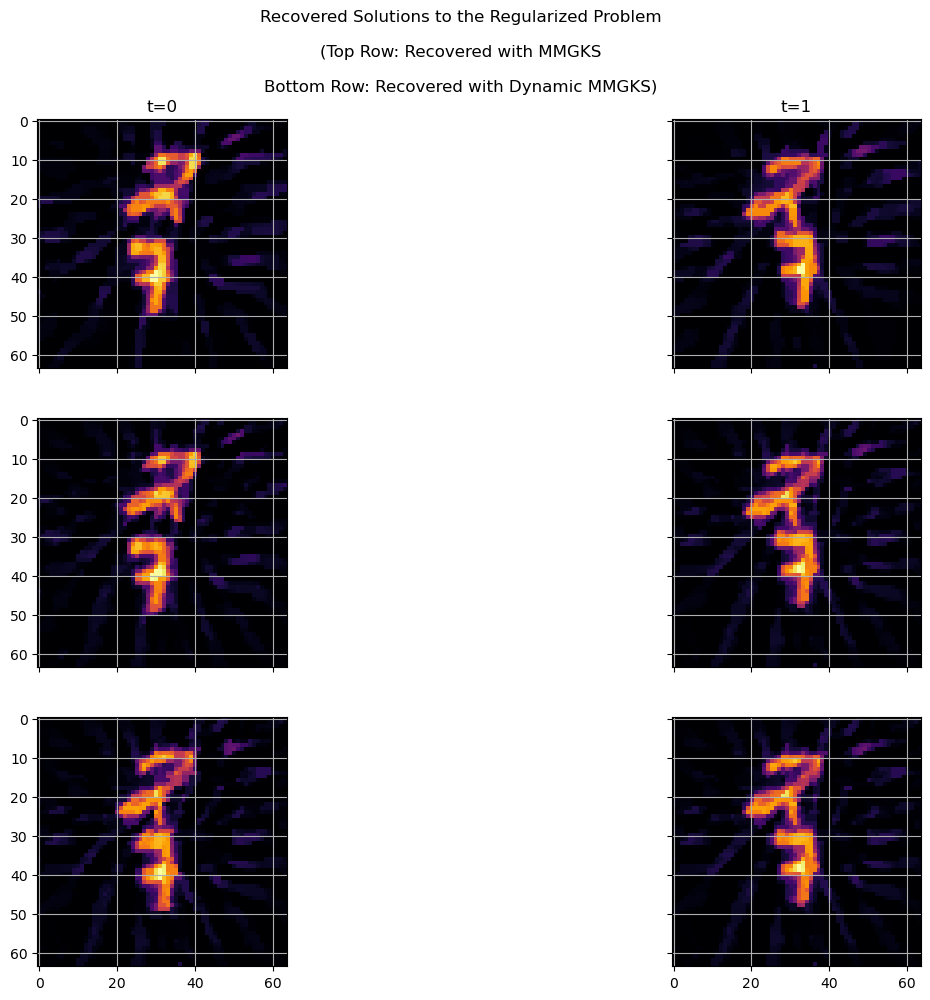

In [22]:
fig,ax=plt.subplots(3,t_end,figsize=(15,11),sharex=True, sharey=True)
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[2,i].imshow(rec_list[::-1][i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    ax[2,i].grid('minor')
plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

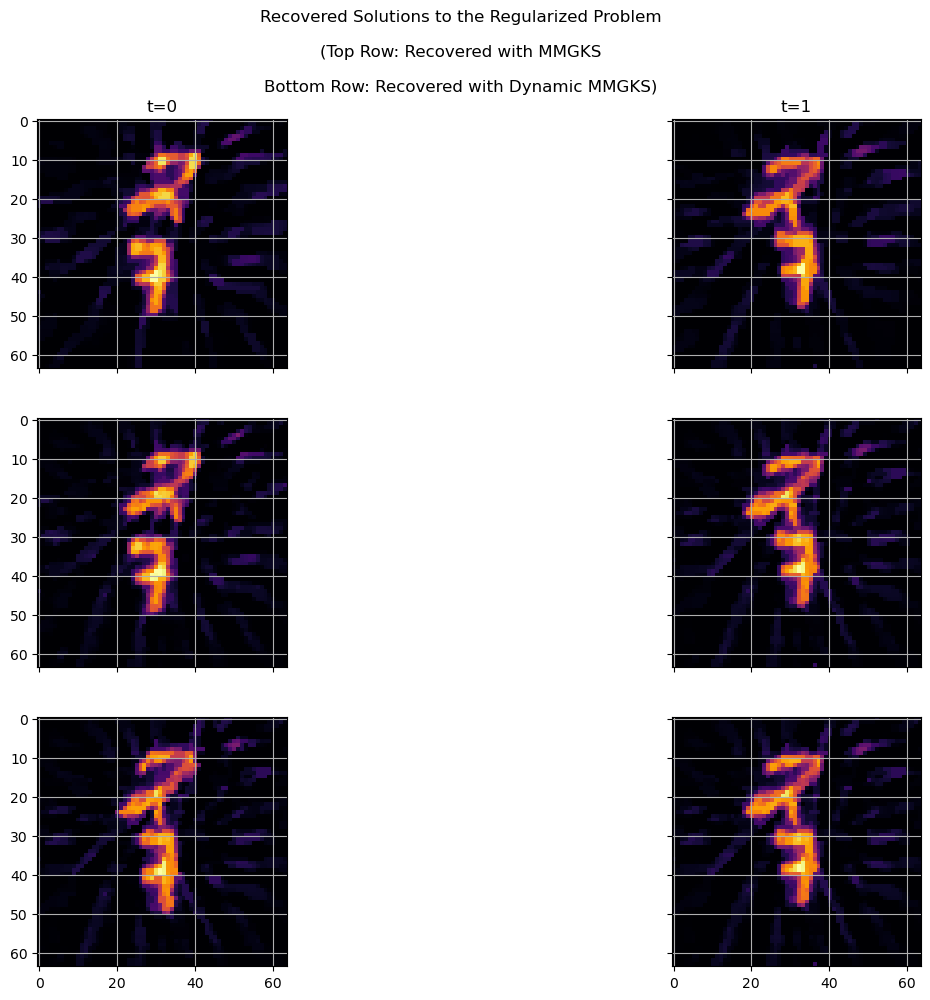

In [25]:
fig,ax=plt.subplots(3,t_end,figsize=(15,11),sharex=True, sharey=True)
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[1,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[2,i].imshow(rec_list[::-1][i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    ax[2,i].grid('minor')
plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

In [70]:
#Generate the sinogram and the operator
views = 5
noise_level = 1e-2
x_traj = u_traj


X_true, A_bar,data_vec_bar,data_vec_true_bar,b_shape,L_bar, I_bar,deltas = gen_joint_tomo_op_and_data(x_traj, t_end, nx,ny, views,
                                                                           noise_level, case='b')
b_size = b_shape[0]*b_shape[1]
delta = np.mean(deltas) #la.norm(data_vec_true_bar-data_vec_bar)
print(delta)


2.8628594970703127


Text(0.5, 0.98, 'Noisy sinograms of the images in the sequence')

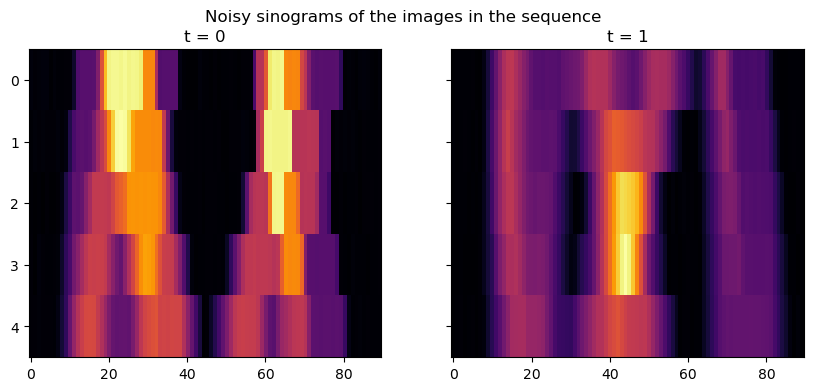

In [71]:
fig,ax=plt.subplots(1,t_end, sharey=True, figsize=(10,4))
data_vec_bar_list_c = [data_vec_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
data_vec_true_bar_list_c = [data_vec_true_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
for i in range(0,t_end):
    ax[i].imshow(data_vec_bar_list_c[i].reshape(b_shape),aspect='auto')
    ax[i].set_title(f't = {i}')
fig.suptitle('Noisy sinograms of the images in the sequence')

In [72]:
#Number of iterations for the optical flow solution


n_iter = 100
n_iter_b = 10
proj_dim = 10
vs_true = None# vs 
v_primes_true= None#v_primes 
reduction = True
scale = 2
epsilon=1e-1
non_neg = False


# MMGKS

from imports import *
from trips.solvers.MMGKS import *
# (X_mmgks_, info_mmgks_) = MMGKS(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
#                         n_iter =n_iter, regparam = 'gcv', x_true = X_true.reshape((-1,1)), epsilon=epsilon,delta=delta)
# error_mmgks_ = info_mmgks_['relError'][-1]
# X_mmgks_list_ = [X_mmgks_[size*i:size*(i+1)] for i in range(t_end)]
# print(error_mmgks_)


# (X_mmgks_2, info_mmgks_2) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
#                         n_iter =n_iter, regparam = 'gcv', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
# error_mmgks_2 = info_mmgks_2['relError'][-1]
# X_mmgks_list_2 = [X_mmgks_2[size*i:size*(i+1)] for i in range(t_end)]
# print(error_mmgks_2)
##MMGKS

(X_mmgks, info_mmgks) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,delta=delta,non_neg=non_neg)
error_mmgks = info_mmgks['relError'][-1]

X_mmgks[X_mmgks<0]=0
X_mmgks_list = [X_mmgks[size*i:size*(i+1)] for i in range(t_end)]

print('MMGKS Solution relative error:', error_mmgks)

## ISO TV
L = gen_spacetime_derivative_operator(nx, ny, t_end)

# Use GKS to compute an approximate solution
(X_TV_iso, info_TV_iso) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
                                regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, isoTV = 'isoTV', prob_dims = (nx,ny, t_end),delta=delta)
error_TV_iso = info_TV_iso['relError'][-1]
X_TV_iso[X_TV_iso<0]=0
X_TV_iso_list = [X_TV_iso[size*i:size*(i+1)] for i in range(t_end)]
print('TV iso Solution relative error:', error_TV_iso)


## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=1, qnorm_opt=1,non_neg=non_neg)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


MMGKS Solution relative error: 0.6075951636273912


running MMGKS...: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


TV iso Solution relative error: 0.562850945616835


running MMGKS...:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\okuno\anaconda3\Lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
running MMGKS...: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

Dynamic MMGKS Solution relative error: 0.5261345628005228


In [ ]:
nt = 10
RRE_opt = [rre(rec_list[i].reshape(nx,ny), X_mmgks_dyn.reshape(nt,nx,ny)[i]) for i in range(nt)]
RRE_opt

[0.19722534158122265,
 0.15366008965462238,
 0.14324769842462876,
 0.1616281956575673,
 0.10358243685342879,
 0.13359325949723913,
 0.15045202990565462,
 0.10061992422881384,
 0.15416899536070255,
 0.0]

In [76]:
(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=2, qnorm_opt=2,non_neg=non_neg)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)

running MMGKS...: 100%|██████████| 100/100 [01:55<00:00,  1.15s/it]

Dynamic MMGKS Solution relative error: 0.5188892629314559


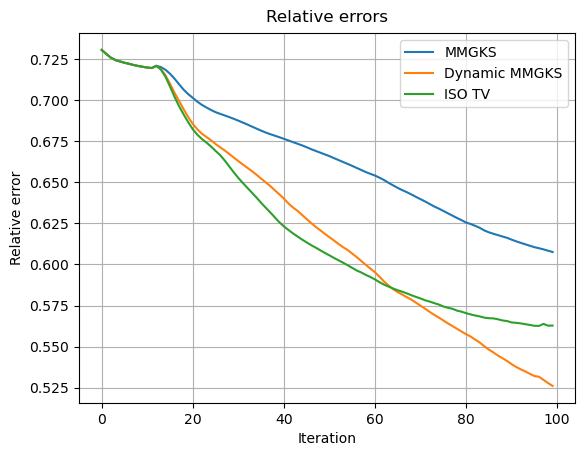

In [74]:
error_mmgks_dyn = info_mmgks_dyn['relError']
error_mmgks = info_mmgks['relError']
error_TV_iso = info_TV_iso['relError']

plt.plot(error_mmgks,label='MMGKS')
plt.plot(error_mmgks_dyn,label='Dynamic MMGKS')
plt.plot(error_TV_iso,label='ISO TV')
plt.legend()
plt.xlabel('Iteration') 
plt.grid('minor')
plt.ylabel('Relative error')
plt.title('Relative errors',va='bottom');

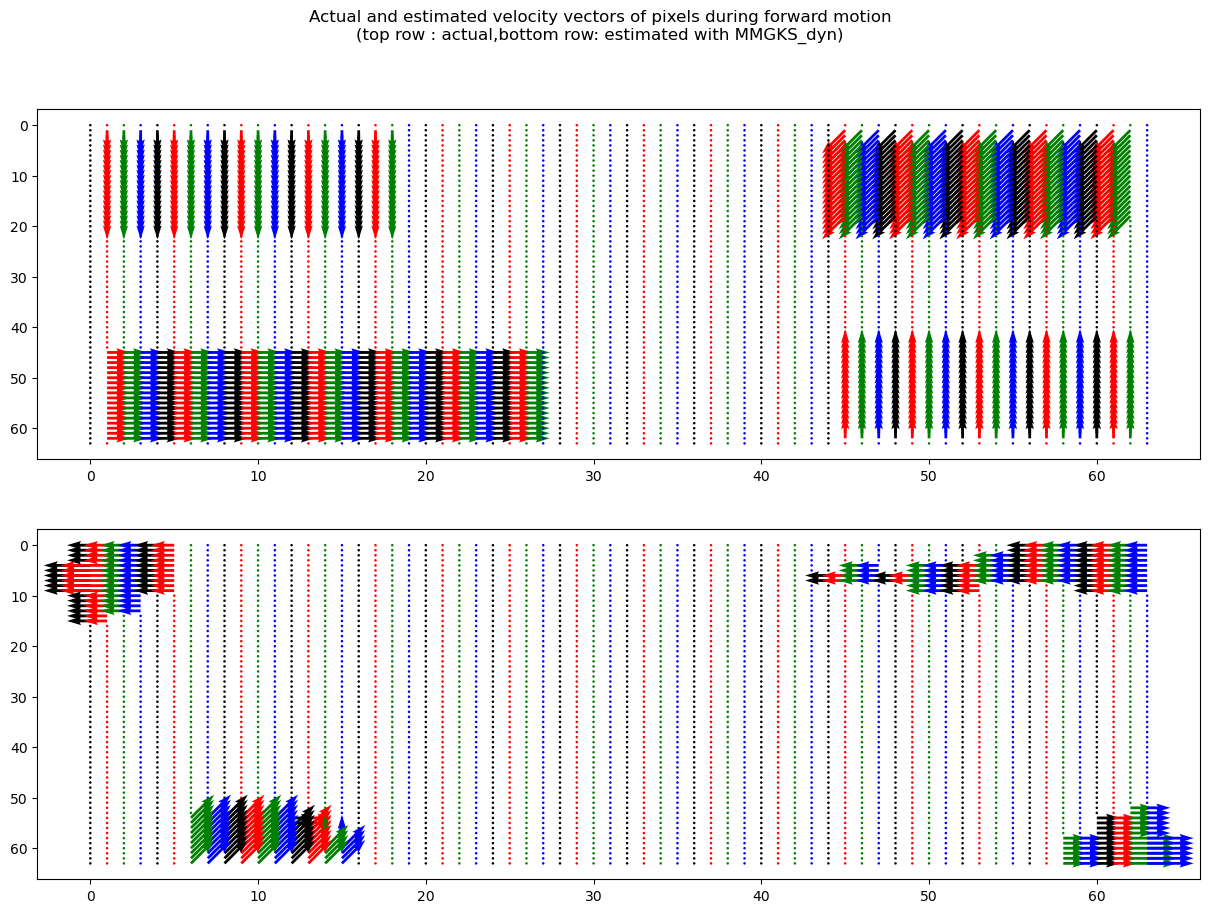

In [73]:
real_0= vs[0].reshape((nx*ny,2))


est_0= np.rint(vs_est[0]).reshape((nx*ny,2))
R = np.array(list(np.ndindex(*shape)))
origin = [np.array(R)[:,1], np.array(R)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(15,10))
if (t_end<=2):
    ax = ax.reshape((-1,1))
for i in range(t_end-1):
    real_0= vs[i].reshape((nx*ny,2))
    est_0= np.rint(vs_est[i]).reshape((nx*ny,2))
    ax[0,i].quiver(*origin, real_0[:, 1], -real_0[:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()

    ax[1,i].quiver(*origin, est_0[:, 1], -est_0[:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[1,i].invert_yaxis()

fig.suptitle('Actual and estimated velocity vectors of pixels during forward motion' + '\n' + '(top row : actual,'+ 
             'bottom row: estimated with MMGKS_dyn)');
plt.show()



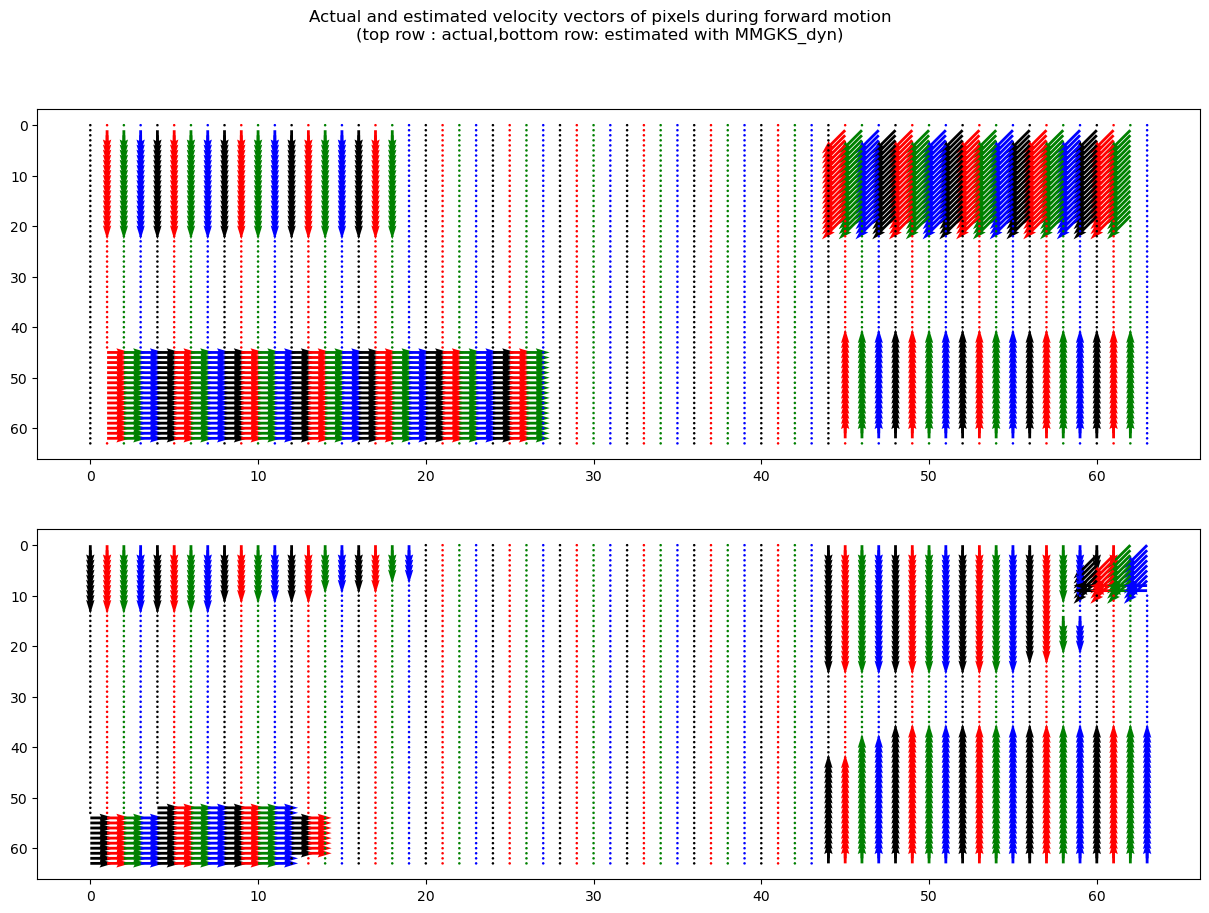

In [38]:
real_0= vs[0].reshape((nx*ny,2))


est_0= np.rint(vs_est[0]).reshape((nx*ny,2))
R = np.array(list(np.ndindex(*shape)))
origin = [np.array(R)[:,1], np.array(R)[:,0]]
#plt.quiver(u_traj[i]_im,v_x.reshape(shape),v_y.reshape(shape), color='g')
fig,ax=plt.subplots(2,t_end-1,figsize=(15,10))
if (t_end<=2):
    ax = ax.reshape((-1,1))
for i in range(t_end-1):
    real_0= vs[i].reshape((nx*ny,2))
    est_0= np.rint(vs_est[i]).reshape((nx*ny,2))
    ax[0,i].quiver(*origin, real_0[:, 1], -real_0[:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[0,i].invert_yaxis()

    ax[1,i].quiver(*origin, est_0[:, 1], -est_0[:, 0], color=['black', 'red', 'green','blue'],scale=50)
    ax[1,i].invert_yaxis()

fig.suptitle('Actual and estimated velocity vectors of pixels during forward motion' + '\n' + '(top row : actual,'+ 
             'bottom row: estimated with MMGKS_dyn)');
plt.show()

